In [4]:
# Import your data toolbox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the raw training data
df = pd.read_csv(r'C:\Users\FENIL\Desktop\Projects\Loan_default\data\processed\cleaned_training.csv')


In [5]:
# Drop unnecessary index column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')


In [6]:
# Step 2: Combine highly correlated delinquency features
delinq_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

if all(col in df.columns for col in delinq_cols):
    df['TotalPastDue'] = df[delinq_cols].sum(axis=1)
    df = df.drop(columns=delinq_cols)

In [7]:
# Step 3: Check for any remaining missing values
print("Missing values per column after cleaning:")
print(df.isnull().sum())

# Step 4:
# Example: Flag for high debt, flag for high income
df['HighDebtRatio'] = (df['DebtRatio'] > 0.5).astype(int)
df['HighIncome'] = (df['MonthlyIncome'] > 10000).astype(int)

Missing values per column after cleaning:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberRealEstateLoansOrLines            0
NumberOfDependents                      0
TotalPastDue                            0
dtype: int64


In [8]:
# Step 5: Review feature list
print("Final features for modeling:", df.columns.tolist())
print(df.head())

Final features for modeling: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'TotalPastDue', 'HighDebtRatio', 'HighIncome']
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  DebtRatio  \
0                 1                              0.766127   45   0.802982   
1                 0                              0.957151   40   0.121876   
2                 0                              0.658180   38   0.085113   
3                 0                              0.233810   30   0.036050   
4                 0                              0.907239   49   0.024926   

   MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
0         9120.0                               13   
1         2600.0                                4   
2         3042.0                                2   
3         3300.0                                5   
4        

### Why Engineer These Features?

**1. TotalPastDue (Engineered Delinquency Total):**
- The original dataset had three separate columns for late payments: 30-59 days, 60-89 days, and 90+ days past due. These are all signals of financial distress, but they overlap and are highly correlated.
- By combining them into a single `TotalPastDue` feature, we create a simple, powerful summary: *"How many times has this person been late on payments?"*
- This makes it easier for models to spot risky customers and reduces redundancy, helping the model focus on what matters most.

**2. HighDebtRatio and HighIncome (Binary Flags):**
- Financial risk often spikes when debt is high or income is unusually large. But models sometimes struggle to pick up on these "threshold" effects if the data is just a continuous number.
- By creating binary flags (`HighDebtRatio`, `HighIncome`), we give the model a clear signal: *"Is this person above a risky level for debt or income?"*
- This can help the model catch patterns that only show up for people with very high debt or income, making predictions more accurate and interpretable.

**In summary:**
- These engineered features simplify the data, highlight important risk signals, and help the model learn patterns that might be missed with raw numbers alone. They also make your analysis easier to explain to others—"high debt" and "total past dues" are concepts everyone understands.

In [9]:
from sklearn.model_selection import train_test_split

# X contains all features except the target
X = df.drop(columns=['SeriousDlqin2yrs'])
# y is the target variable (loan default)
y = df['SeriousDlqin2yrs']

# Split the data so you can test your model on unseen cases
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (120000, 10), Validation set: (30000, 10)


In [11]:
# Step 2: Standardize features so all numbers are on a similar scale (helps the model!)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [12]:
# Step 3: Build logistic regression model (simple, interpretable, and a solid baseline)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

Validation ROC-AUC: 0.8089831948081216
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     27995
           1       0.18      0.67      0.28      2005

    accuracy                           0.77     30000
   macro avg       0.58      0.73      0.57     30000
weighted avg       0.92      0.77      0.83     30000



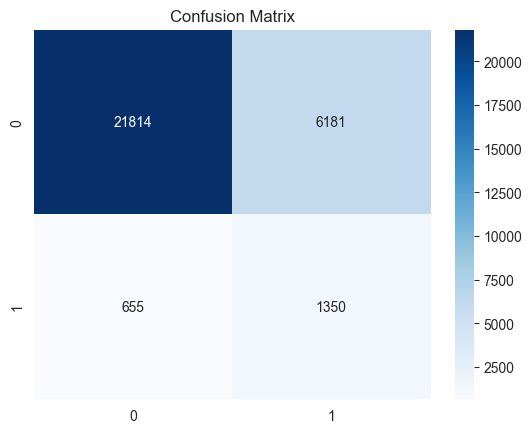

In [13]:
# Step 4: Evaluate with  metrics!
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = model.predict_proba(X_val_scaled)[:, 1]
y_pred = model.predict(X_val_scaled)

print('Validation ROC-AUC:', roc_auc_score(y_val, y_pred_prob))
print(classification_report(y_val, y_pred))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Step 5: See which features matter most!
import numpy as np
feature_names = X.columns
importances = np.abs(model.coef_[0])
sorted_idx = np.argsort(importances)[::-1]

print("Top features driving predictions:")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Top features driving predictions:
TotalPastDue: 5.0326
age: 0.4246
HighDebtRatio: 0.2397
DebtRatio: 0.1960
MonthlyIncome: 0.1076
NumberOfDependents: 0.0788
NumberRealEstateLoansOrLines: 0.0314
NumberOfOpenCreditLinesAndLoans: 0.0287
HighIncome: 0.0120
RevolvingUtilizationOfUnsecuredLines: 0.0042
